# Autoencoder cf study #1
<hr style='height:5px'>
kwanki.ahn<br>
2019/06/01 skeleton<br>
2019/06/03 update model, add metrics<br>
ref : 
<hr style='height:5px'>

* Data loader

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.metrics.pairwise import pairwise_distances

In [3]:
def get_users_items_ratings_nparray():
    # movielens dataset : https://old.datahub.io/dataset/movielens
    USERS_PATH = 'dataset/ml-1m/users.dat'
    MOVIES_PATH = 'dataset/ml-1m/movies.dat'
    RATINGS_PATH = 'dataset/ml-1m/ratings.dat'
    
    # data processing : https://github.com/khanhnamle1994/movielens/blob/master/Data_Processing.ipynb
    # Specify User's Age and Occupation Column
    AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
    OCCUPATIONS = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                    4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                    7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                    12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                    17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }
    
    # Read the Ratings File
    ratings = pd.read_csv(RATINGS_PATH, 
                        sep='::', 
                        engine='python', 
                        encoding='latin-1',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])

    # Set max_userid to the maximum user_id in the ratings
    max_userid = ratings['user_id'].drop_duplicates().max()
    # Set max_movieid to the maximum movie_id in the ratings
    max_movieid = ratings['movie_id'].drop_duplicates().max()

    # Process ratings dataframe for Keras Deep Learning model
    # Add user_emb_id column whose values == user_id - 1
    ratings['user_emb_id'] = ratings['user_id'] - 1
    # Add movie_emb_id column whose values == movie_id - 1
    ratings['movie_emb_id'] = ratings['movie_id'] - 1

    print(len(ratings), 'ratings loaded')
    
    # Read the Users File
    users = pd.read_csv(USERS_PATH, 
                        sep='::', 
                        engine='python', 
                        encoding='latin-1',
                        names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
    users['age_desc'] = users['age'].apply(lambda x: AGES[x])
    users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])
    print(len(users), 'descriptions of', max_userid, 'users loaded.')
    
    # Read the Movies File
    movies = pd.read_csv(MOVIES_PATH, 
                        sep='::', 
                        engine='python', 
                        encoding='latin-1',
                        names=['movie_id', 'title', 'genres'])
    print(len(movies), 'descriptions of', max_movieid, 'movies loaded.')
    
    return users, movies, ratings

In [4]:
def check_stats(users, movies, ratings):
    n_user = len(users)
    n_item = len(movies)
    n_rating = len(ratings)
    n_matrix_size = n_user * n_item
    n_sparsity = (1 - (float(n_rating) / float(n_matrix_size))) * 100
    print("users : {}, items : {}, ratings : {}, sparsity : {} %".format(n_user, n_item, n_rating, n_sparsity))
    print("user_id max : {}, movie_id max : {}".format(users['user_id'].max(), movies['movie_id'].max()))
    return n_user, n_item, n_rating, n_matrix_size, n_sparsity

In [5]:
def build_dict_of_data(users, movies, ratings):
    user2idx = {}
    idx2user = {}
    movie2idx = {}
    idx2movie = {}

    for idx, row in users.iterrows():
        user2idx[row['user_id']] = idx
        idx2user[idx] = row['user_id']
    for idx, row in movies.iterrows():
        movie2idx[row['movie_id']] = idx
        idx2movie[idx] = row['movie_id']
    return user2idx, idx2user, movie2idx, idx2movie

In [6]:
def build_ratings_matrix(ratings, user2idx, movie2idx):
    r_matrix = np.zeros((n_user, n_item), dtype='i')
    for index, row in ratings.iterrows():
        user_idx = user2idx[row['user_id']]
        movie_idx = movie2idx[row['movie_id']]
        rating = row['rating']
        r_matrix[user_idx][movie_idx] = 1  # rating
    return r_matrix

* Model

In [7]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

def build_autoencoder_model(x_train, latent_size=[1000, 50]):
    # input dimension = 784
    input_dim = x_train.shape[1]
    inter_dim = latent_size[0]
    rep_dim = latent_size[1]  # latent_size  # 32

    compression_factor = float(input_dim) / rep_dim
    print("Compression factor: %s" % compression_factor)

    autoencoder = Sequential()
    autoencoder.add(
        Dense(inter_dim, input_shape=(input_dim,), activation='selu')
    )
    autoencoder.add(
        Dense(rep_dim, activation='selu')
    )
    autoencoder.add(
        Dense(inter_dim, activation='selu')
    )
    autoencoder.add(
        Dense(input_dim, activation='sigmoid')
    )

    autoencoder.summary()
    
    return autoencoder

Using TensorFlow backend.
/home/kwankiahn/setup/venv-3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kwankiahn/setup/venv-3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kwankiahn/setup/venv-3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kwankiahn/setup/venv-3/lib/pytho

* Verify

In [8]:
def show_history_of_user(ratings, movies, sample_user_id=100, item_number=15):
    print("== get_history_of_user(), user id = {}".format(sample_user_id))
    history_with_id_rating = (ratings.loc[ratings['user_id'] == sample_user_id][['movie_id', 'rating']]
            .sort_values(["rating"], ascending=[False])[:item_number])
    history_with_meta = pd.merge(history_with_id_rating, movies, on='movie_id')
    return history_with_meta

In [9]:
def get_recommend_of_user_raw(model, r_matrix, user2idx, movies, sample_user_id=100, debug=False):
    if debug is True:
        print("== get_recommend_of_user_raw(), user id = {}".format(sample_user_id))
    # reshape 1 by x => x by 1
    history_of_user = r_matrix[user2idx[sample_user_id]]
    shape_len = history_of_user.shape[0]
    history_of_user = history_of_user.reshape((1, shape_len))
    score_list = model.predict(history_of_user).flatten()
    if debug is True:
        print("  result raw : shape = {}, max = {}, min = {}".format(score_list.shape, score_list.max(), score_list.min()))
    return score_list

In [10]:
def get_watched_remove(recommends_raw, r_matrix, user2idx, idx2movie, sample_user_id=100):
    print("== get_watched_remove() ==")
    
    # remove watched
    rating_of_user = r_matrix[user2idx[sample_user_id]]
    print(rating_of_user.shape)

    recommends_watch_removed = []
    for idx in range(0, len(recommends_raw)):
        if rating_of_user[idx] == 0:  # FALSE == if user watched idx program already
            recommends_watch_removed.append((idx2movie[idx], recommends_raw[idx]))
            
    return recommends_watch_removed

In [11]:
def show_recommend_of_user(model, r_matrix, user2idx, idx2movie, movies, sample_user_id=100, item_number=15):
    print("== get_recommend_of_user(), user id : {} ==".format(sample_user_id))
    # model's output (raw) : list of scores, length is item count, from index 0 (idx2movie needs)
    recommends_raw = get_recommend_of_user_raw(model, r_matrix, user2idx, movies, sample_user_id)
    
    # remove watched (from rating matrix, allow only if not rating score is 0) -> [(movie id, score)]
    remove_watched = get_watched_remove(recommends_raw, r_matrix, user2idx, idx2movie, sample_user_id)
    
    # select top n
    from operator import itemgetter
    remove_watched.sort(key=itemgetter(1), reverse=True)
    remove_watched = remove_watched[:item_number]

    recommend_df = pd.DataFrame(np.array(remove_watched))
    recommend_df.columns = ['movie_id', 'inferred_score']
    recommend_df = recommend_df.astype({"movie_id": int, "inferred_score": float})
    recommend_with_meta = pd.merge(recommend_df, movies, on='movie_id')
    return recommend_with_meta

# MAIN

## DATA

In [12]:
users, movies, ratings = get_users_items_ratings_nparray()

1000209 ratings loaded
6040 descriptions of 6040 users loaded.
3883 descriptions of 3952 movies loaded.


In [29]:
ratings[:10]

,user_id,movie_id,rating,timestamp,user_emb_id,movie_emb_id
0,1,1193,5,978300760,0,1192
1,1,661,3,978302109,0,660
2,1,914,3,978301968,0,913
3,1,3408,4,978300275,0,3407
4,1,2355,5,978824291,0,2354
5,1,1197,3,978302268,0,1196
6,1,1287,5,978302039,0,1286
7,1,2804,5,978300719,0,2803
8,1,594,4,978302268,0,593
9,1,919,4,978301368,0,918


In [26]:
users[:10]

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer
5,6,F,50,9,55117,50-55,homemaker
6,7,M,35,1,06810,35-44,academic/educator
7,8,M,25,12,11413,25-34,programmer
8,9,M,25,17,61614,25-34,technician/engineer
9,10,F,35,1,95370,35-44,academic/educator


In [27]:
movies[:10]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [28]:
n_user, n_item, n_rating, n_matrix_size, n_sparsity = check_stats(users, movies, ratings)
user2idx, idx2user, movie2idx, idx2movie = build_dict_of_data(users, movies, ratings)
len(user2idx), len(idx2user), len(movie2idx), len(idx2movie)

users : 6040, items : 3883, ratings : 1000209, sparsity : 95.73532020200125 %
user_id max : 6040, movie_id max : 3952


(6040, 6040, 3883, 3883)

In [31]:
r_matrix = build_ratings_matrix(ratings, user2idx, movie2idx)

In [ ]:
# UNIT TEST
# user_id_test = 3491
# history = (ratings.loc[ratings['user_id'] == user_id_test][['movie_id', 'rating']]
#             .sort_values(["rating"], ascending=[False])[:20])
# history
# compare history vs ratings raw data file 45's rating scores

## MODEL

In [ ]:
autoencoder = build_autoencoder_model(r_matrix, latent_size = [600, 20])

In [ ]:
opt = keras.optimizers.Adam(lr=0.001)
# opt = 'adam'

In [20]:
autoencoder.compile(optimizer=opt, loss='mean_squared_error')
hist = autoencoder.fit(r_matrix, r_matrix,
                epochs=80,
                batch_size=256,
                shuffle=True
                # validation_data=(x_test, x_test)
               )

Epoch 1/80
6040/6040 [==============================] - 5s - loss: 0.0814     
Epoch 2/80
6040/6040 [==============================] - 3s - loss: 0.0370     
Epoch 3/80
6040/6040 [==============================] - 3s - loss: 0.0364     
Epoch 4/80
6040/6040 [==============================] - 3s - loss: 0.0359     
Epoch 5/80
6040/6040 [==============================] - 3s - loss: 0.0355     
Epoch 6/80
6040/6040 [==============================] - 3s - loss: 0.0350     
Epoch 7/80
6040/6040 [==============================] - 3s - loss: 0.0346     
Epoch 8/80
6040/6040 [==============================] - 3s - loss: 0.0342     
Epoch 9/80
6040/6040 [==============================] - 3s - loss: 0.0339     
Epoch 10/80
6040/6040 [==============================] - 3s - loss: 0.0332     
Epoch 12/80
6040/6040 [==============================] - 3s - loss: 0.0329     
Epoch 13/80
6040/6040 [==============================] - 3s - loss: 0.0325     
Epoch 14/80
6040/6040 [==========================

In [21]:
def show_train_progress(hist):
    # https://tykimos.github.io/2017/07/09/Training_Monitoring/
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
#     loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#     acc_ax.plot(hist.history['acc'], 'b', label='train acc')
#     acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

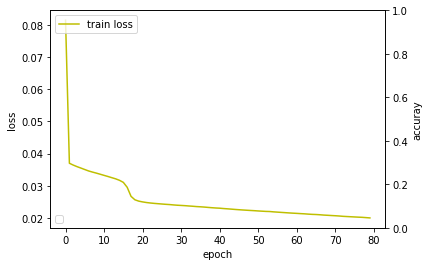

In [22]:
show_train_progress(hist)

## VERIFY (eye checking)

In [23]:
show_history_of_user(ratings, movies, sample_user_id=47)

== get_history_of_user(), user id = 47


,movie_id,rating,title,genres
0,36,5,Dead Man Walking (1995),Drama
1,527,5,Schindler's List (1993),Drama|War
2,1041,5,Secrets & Lies (1996),Drama
3,17,5,Sense and Sensibility (1995),Drama|Romance
4,858,4,"Godfather, The (1972)",Action|Crime|Drama
5,1221,4,"Godfather: Part II, The (1974)",Action|Crime|Drama
6,1213,4,GoodFellas (1990),Crime|Drama
7,1208,4,Apocalypse Now (1979),Drama|War
8,34,4,Babe (1995),Children's|Comedy|Drama
9,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama


In [24]:
show_recommend_of_user(autoencoder, r_matrix, user2idx, idx2movie, movies, sample_user_id=47)

== get_recommend_of_user(), user id : 47 ==
== get_watched_remove() ==
(3883,)


,movie_id,inferred_score,title,genres
0,296,0.613964,Pulp Fiction (1994),Crime|Drama
1,2028,0.425166,Saving Private Ryan (1998),Action|Drama|War
2,1704,0.368135,Good Will Hunting (1997),Drama
3,1225,0.356992,Amadeus (1984),Drama
4,1617,0.343891,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
5,912,0.294362,Casablanca (1942),Drama|Romance|War
6,919,0.285976,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
7,2858,0.251799,American Beauty (1999),Comedy|Drama
8,1961,0.243311,Rain Man (1988),Drama
9,1097,0.227496,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi


## METRIC

### AUC
<hr style='height:5px'>

In [33]:
def get_watched_nowatched_id_list(user_id, model, r_matrix, user2idx, idx2movie, debug=False):
    watched_l = []
    nowatched_l = []
    user_history = r_matrix[user2idx[user_id]]  # rating (watched) history
    for idx, r, in enumerate(user_history):
        if r != 0:
            watched_l.append(idx2movie[idx])
        else:
            nowatched_l.append(idx2movie[idx])
    if debug is True:
        print("  watched_l : {}..., len : {}".format(watched_l[:10], len(watched_l)))
        print("  nowatched_l : {}..., len : {}".format(nowatched_l[:10], len(nowatched_l)))
    return watched_l, nowatched_l

In [34]:
def get_auc_score(user_id, model, r_matrix, user2idx, idx2movie, movies, item_k=100, debug=False):
    # refer : http://hyunje.com/data%20analysis/2015/07/27/advanced-analytics-with-spark-ch3-2/
    # corrent = number of 본것's predict rating > 안본것's predict rating
    # auc = correct / total test number
    
    if debug is True:
        print("get_auc_score() start, user id : {}".format(user_id))
        
    watched_l, nowatched_l = get_watched_nowatched_id_list(user_id, model, r_matrix, user2idx, idx2movie, debug=False)
    candidate_len = min(len(watched_l), len(nowatched_l))
    if item_k > candidate_len:
        item_k = candidate_len
    if debug is True:
        print("  candidate_len : {}, item_k : {}".format(candidate_len, item_k))
    
    recommends_raw = get_recommend_of_user_raw(model, r_matrix, user2idx, movies, user_id)

    import random
    random_index_l = random.sample(range(0, candidate_len), item_k) 
    watched_sample_k = [watched_l[x] for x in random_index_l]
    nowatched_sample_k = [nowatched_l[x] for x in random_index_l]
    
    if debug is True:
        print("  watched_sample_k : {}..., len : {}".format(watched_sample_k[:10], len(watched_sample_k)))
        print("  nowatched_sample_k : {}..., len : {}".format(nowatched_sample_k[:10], len(nowatched_sample_k)))
    
    correct = 0
    for i in range(0, item_k):
        if recommends_raw[movie2idx[watched_sample_k[i]]] > recommends_raw[movie2idx[nowatched_sample_k[i]]]:
            correct += 1
    return float(correct) / float(item_k)

In [27]:
# AUC SCORE of single person
get_auc_score(47, autoencoder, r_matrix, user2idx, idx2movie, movies, item_k=150)

0.9545454545454546

In [28]:
# AUC SCORE of 500 person average
k = 400
import random
r_user_idx = random.sample(range(0, len(users)), k)

auc_agg = []
for u in r_user_idx:
    auc_agg.append(get_auc_score(idx2user[u], autoencoder, r_matrix, user2idx, idx2movie, movies, item_k=150))

== STATS ==
  AUC : 0.916949312534 (avg of 400 users)
  max : 1.0, min : 0.571428571429, median : 0.926666666667


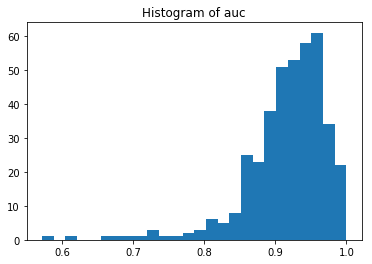

In [29]:
print("== STATS ==")
print("  AUC : {} (avg of {} users)".format(np.average(auc_agg), k))
print("  max : {}, min : {}, median : {}".format(max(auc_agg), min(auc_agg), np.median(auc_agg)))
plt.hist(auc_agg, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of auc")
plt.show()

### TOP K ACCURACY
<hr style='height:5px'>

In [30]:
def check_watched_item_score_is_in(recommends_raw, watched_l, nowatched_l, candidate_len, idx2movie, k, base, debug=False):
    import random
    random_index_l = random.sample(range(0, candidate_len), base) 
    watched_sample_1 = [watched_l[x] for x in random_index_l][0]
    nowatched_sample_99 = [nowatched_l[x] for x in random_index_l][:base-1]
    
    if debug is True:
        print("  watched_sample_k : {}..., len : {}".format(watched_sample_k[:10], len(watched_sample_k)))
        print("  nowatched_sample_k : {}..., len : {}".format(nowatched_sample_k[:10], len(nowatched_sample_k)))
    
    # sorted nowatch 99 score
    scores = []
    for i in nowatched_sample_99:
        scores.append(recommends_raw[movie2idx[i]])
    scores.sort(reverse=True)
    
    # watched 1 score
    score_watched = recommends_raw[movie2idx[watched_sample_1]]
    if score_watched >= scores[k]:
        return True
    return False

In [31]:
def get_topk_accuracy(user_id, model, r_matrix, user2idx, idx2movie, movies, k = 10, base=100, debug=False):
    if debug is True:
        print("get_topk_accuracy() start, user id : {}".format(user_id))
        
    watched_l, nowatched_l = get_watched_nowatched_id_list(user_id, model, r_matrix, user2idx, idx2movie, debug=False)
    candidate_len = min(len(watched_l), len(nowatched_l))
    if base > candidate_len:
        base = candidate_len
    if debug is True:
        print("  candidate_len : {}, k : {}, base : {}".format(candidate_len, k, base))
        
    recommends_raw = get_recommend_of_user_raw(model, r_matrix, user2idx, movies, user_id)
    
    hit = 0
    for i in range(0, 100):  # single person, 100 iteration (-> picking 1 watch, 99 nowatch (1 + 99 = # of base), and check watched is under k-th order)
        if check_watched_item_score_is_in(recommends_raw, watched_l, nowatched_l, candidate_len, idx2movie, k, base, debug=False) is True:
            hit += 1
    return float(hit) / float(100) 

In [32]:
# TOP K Score of single person
get_topk_accuracy(45, autoencoder, r_matrix, user2idx, idx2movie, movies, k=10, base=100, debug=True)

get_topk_accuracy() start, user id : 45
  candidate_len : 297, k : 10, base : 100


0.97

In [33]:
# TOP K SCORE of 500 person average
k = 200
import random
r_user_idx = random.sample(range(0, len(users)), k)

score_agg = []
for u in r_user_idx:
    score_agg.append(get_topk_accuracy(idx2user[u], autoencoder, r_matrix, user2idx, idx2movie, movies, k=10, base=100, debug=False))

== STATS ==
  TOP-K ACCURACY : 0.84155 (avg of 200 users)
  max : 1.0, min : 0.17, median : 0.85


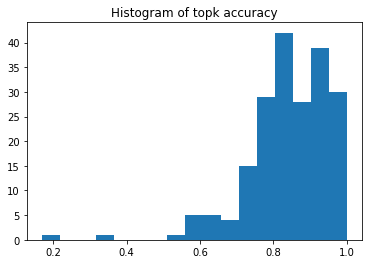

In [34]:
print("== STATS ==")
print("  TOP-K ACCURACY : {} (avg of {} users)".format(np.average(score_agg), k))
print("  max : {}, min : {}, median : {}".format(max(score_agg), min(score_agg), np.median(score_agg)))
plt.hist(score_agg, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of topk accuracy")
plt.show()

### HIT RATION@K
<hr style='height:5px'>

In [35]:
def check_howmany_watched_is_recommended(recommends_raw_with_index, watched_l, nowatched_l, candidate_len, idx2movie, base, debug=True):
    if debug is True:
        print("check_top_n_includes_watched() start")
        print("  watched_l : {}".format(watched_l))
        
    hit = 0
    for index, score in recommends_raw_with_index:
        if debug is True:
            print("  checking index : {} (idx2movie -> {}), score : {}".format(index, idx2movie[index], score))
        if idx2movie[index] in watched_l:
            if debug is True:
                print("hit!!! ")
            hit += 1
    return float(hit) / float(len(watched_l))

In [36]:
def get_hitratio_n(user_id, model, r_matrix, user2idx, idx2movie, movies, base=100, debug=False):
    if debug is True:
        print "get_hitration_n() start, user id : {}".format(user_id)
        
    watched_l, nowatched_l = get_watched_nowatched_id_list(user_id, model, r_matrix, user2idx, idx2movie, debug)
    candidate_len = min(len(watched_l), len(nowatched_l))
    if base > candidate_len:
        base = candidate_len
    if debug is True:
        print "  candidate_len : {}, base : {}".format(candidate_len, base)
        
    recommends_raw = get_recommend_of_user_raw(model, r_matrix, user2idx, movies, user_id)
    recommends_raw_with_index = [(idx, score) for idx, score in enumerate(recommends_raw)]
    from operator import itemgetter
    recommends_raw_with_index.sort(key=itemgetter(1), reverse=True)
    
    if debug is True:
        print "recommends_raw_with_index[:{}] is : {}".format(base, recommends_raw_with_index[:base])
    
    score = check_howmany_watched_is_recommended(recommends_raw_with_index[:base], watched_l, nowatched_l, candidate_len, idx2movie, base, debug)
    return score

In [37]:
# HR@K Score of single person
HRK = 100
get_hitratio_n(45, autoencoder, r_matrix, user2idx, idx2movie, movies, base=HRK, debug=False)

0.2760942760942761

In [38]:
# HR@K SCORE of 500 person average
k = 200
import random
r_user_idx = random.sample(range(0, len(users)), k)

score_agg = []
for u in r_user_idx:
    score_agg.append(get_hitratio_n(idx2user[u], autoencoder, r_matrix, user2idx, idx2movie, movies, base=HRK, debug=False))

== STATS ==
  HR@100 ACCURACY : 0.429697829971 (avg of 200 users)
  max : 0.822784810127, min : 0.0936007640879, median : 0.439907407407


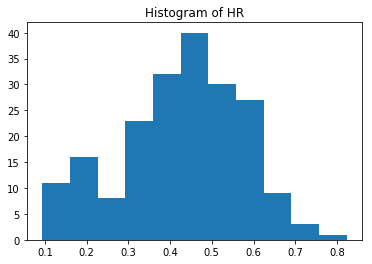

In [39]:
print "== STATS =="
print "  HR@{} ACCURACY : {} (avg of {} users)".format(HRK, np.average(score_agg), k)
print "  max : {}, min : {}, median : {}".format(max(score_agg), min(score_agg), np.median(score_agg))
plt.hist(score_agg, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of HR")
plt.show()